# Memefly Image Captioning Word Level

Inspired by [Show, Attend and Tell: Neural Image Caption Generation with Visual Attention](https://arxiv.org/abs/1502.03044), [Dank Learning: Generating Memes Using Deep Neural Networks](https://arxiv.org/abs/1806.04510), and [CS231n Assignment 3](http://cs231n.github.io/assignments2019/assignment3/). 

Code references [Image captioning with visual attention](https://www.tensorflow.org/tutorials/text/image_captioning), [Text generation with an RNN](https://www.tensorflow.org/tutorials/text/text_generation)

In [13]:
import os
import sys

sys.path.append(os.path.abspath('../datasets'))
sys.path.append(os.path.abspath('../weights'))

import pathlib
import time
import pickle
import json
from tqdm import tqdm
import ipykernel
import requests
import shutil
from typing import List, Dict, Tuple, Sequence

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, GRU, Add, add, Attention, RepeatVector, AdditiveAttention
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.model_selection import train_test_split

# import wandb
# from wandb.keras import WandbCallback

# os.environ['WANDB_NOTEBOOK_NAME'] = '10_meme_word_gen_model_3.2.2'
np.random.seed(45)

# 1. CONFIG

In [2]:
class Config:
    DATA_VERSION = 'v2'
    MODEL_TYPE = 'word'
    TIMESTAMP = time.strftime('%Y%m%d%H%M')
    TOKENIZER = f'../weights/memefly-{MODEL_TYPE}-data-{DATA_VERSION}-tokenizer.pkl'
    IMAGE_MODEL_FILENAME = "../weights/inceptionv3_embeddings.h5"

INPUT_JSON_FILE = '../datasets/combined_data.json'
DESCRIPTION_FILE = f'../datasets/memefly-{Config.DATA_VERSION}-descriptions.txt'
IMG_FEATURES_PKL = f'../datasets/memefly-{Config.DATA_VERSION}-features.pkl'

# 2. Data Loading and Preprocessing

In [3]:
class MemeflyDataset:
    def __init__(self, *, input_json_file: str, img_model: tf.keras.Model, description_file: str, img_features_pkl: str):
        self.json_data = self.__load_json(input_json_file)
        self.description_file = description_file
        self.img_features_pkl = img_features_pkl
        self.img_model = tf.keras.models.load_model(img_model, compile=False)
        self.tokenizer = None
        self.max_length = None
        self.vocab_size = None
        self.text_data = None
        self.img_data = None

    def __load_json(self, path: str):
        """ Loads json file """
        try:
            with open(path) as robj:
                data = json.load(robj)
            return data
        except Exception as e:
            raise e
        
    def preprocess_text(self):
        """
        Preprocess input_json and save to instance attributes
        
        Generates:
        ========
        description_file: meme_name meme_text file, for sanity checking and debugging
        tokenizer: tf.keras tokenizer
        vocab_size: size of the tokenizer, int
        max_length: maximum length of meme text, int
        text_data: list of [meme_name, meme_text] pairs
        """
        print("Preprocessing text ...")
        corpus = []
        meme_data = []
        with open(self.description_file, 'w') as outfile:
            for row in iter(self.json_data):
                meme_name = row["meme_name"]
                for meme_text in row["meme_text"]:
                    meme_text = f"startseq {meme_text} endseq\n"
                    #text = f"{meme_name} startseq {meme_text} endseq\n"
                    corpus.append(meme_text.rstrip())#.split(' '))
                    meme_data.append([meme_name, meme_text.rstrip()])
                    outfile.write(f"{meme_name} {meme_text}")#text)
        
        tokenizer = Tokenizer(lower=True)
        tokenizer.fit_on_texts(corpus)
        pickle.dump(tokenizer, open(Config.TOKENIZER, 'wb'))
        
        self.tokenizer = tokenizer
        self.vocab_size = len(tokenizer.word_index) + 1
        self.text_data = meme_data
        self.max_length = len(max([item[1] for item in meme_data], key=len))
        
        pass

    def preprocess_img(self):
        """
        Preprocess input_json and save to instance attributes
        
        Generates:
        ========
        images files: downloaded image file given the urls
        img_features_pkl: pickled dictionary of {meme_name: img_vec file}
        img_data: dictionary of {meme_name: img_vec file}
        """
        print("Preprocessing images ...")
        img_urls = [item['meme_url'] for item in self.json_data]
        meme_names = [item['meme_name'] for item in self.json_data]
        self.__download_images(img_urls, meme_names)
        self.img_data = self.__extract_features(meme_names)
        
        pass
    
    def __download_images(self, url_list: List, meme_name: List):
        """ Download meme images from 'meme_url', skip if already exists """
        print("Downloading images ...")
        count = 0
        for i in tqdm(range(len(url_list))):
            filename = f"../datasets/images/{meme_name[i]}.jpg"
            if not pathlib.Path(filename).exists():
                r = requests.get(url_list[i], 
                                 stream=True,
                                 #headers={'User-agent': 'Mozilla/5.0'}
                                )
                if r.status_code == 200:
                    count += 1

                    with open(filename, 'wb') as f:
                        r.raw.decode_content = True
                        shutil.copyfileobj(r.raw, f)
        if count == len(url_list):
            print("all images in url_list downloaded")
            
        pass
    
    def __extract_features(self, meme_name: list) -> dict:
        """
        Takes a preloaded Tensorflow Keras InceptionV3 Model with embeddings and a list of images
        and return a dict with keys: image_name w/o the .jpg and the values: image embeddings extracted
        using InceptionV3 with global average pooling layer and pretrained imagenet weights.
        """
        print("Creating image embedding vectors ...")
        features = dict()
        for img_file in tqdm(meme_name):
            filename = f"../datasets/images/{img_file}.jpg"
            img = load_img(filename, target_size=(299, 299))
            img = img_to_array(img)
            img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
            img = preprocess_input(img)
            feature = self.img_model.predict(img, verbose=0)
            features[img_file] = feature
            
            pickle.dump(features, open(self.img_features_pkl, 'wb'))
            
        return features

In [4]:
dataset = MemeflyDataset(input_json_file=INPUT_JSON_FILE,
                         img_model=Config.IMAGE_MODEL_FILENAME, 
                         description_file=DESCRIPTION_FILE, 
                         img_features_pkl=IMG_FEATURES_PKL)
dataset.preprocess_text()
dataset.preprocess_img()

meme_dataset = dataset.text_data
MEME_IMG_VEC = dataset.img_data
VOCAB_SIZE = dataset.vocab_size
MAX_LENGTH = dataset.max_length
TOKENIZER = dataset.tokenizer
print(f"Full data: {len(meme_dataset)}\nmemes images: {len(MEME_IMG_VEC)}\nVocab size: {VOCAB_SIZE}\nMax meme length: {MAX_LENGTH}\n")

train_dataset, val_dataset = train_test_split(meme_dataset, test_size=0.05)
print(len(train_dataset), len(val_dataset))

Preprocessing text ...


  0%|                                                                                          | 0/108 [00:00<?, ?it/s]

Preprocessing images ...
Creating image embedding vectors ...


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:14<00:00,  7.67it/s]

Full data: 20443
memes images: 108
Vocab size: 17240
Max meme length: 150

19420 1023


# 5. Data Generator

In [6]:
class MemeDataGenerator(tf.keras.utils.Sequence):
    """
    An iterable that returns [batch_size, (images embeddigns, [unrolled input text sequences, text target])].
    Instead of batching over images, we choose to batch over [image, description] pairs because unlike typical
    image captioning tasks that has 3-5 texts per image, we have 180-200 texts per image. Batching over images
    in our case significantly boosted memory cost and we could only batch 1-2 images using AWS p2.xLarge or
    p3
    
    This class inherets from tf.keras.utils.Sequences to avoid data redundancy and syncing error.
    https://www.tensorflow.org/api_docs/python/tf/keras/utils/Sequence
    https://keras.io/utils/#sequence
    
    dataset: [meme name, meme text] pairs
    shuffle: If True, shuffles the samples before every epoch
    batch_size: How many images to return in each call
    
    INPUT:
    ========
    - dataset: list of meme_name and meme_text pairs. [[meme_name, meme_text], [...], ...]
    - img_embds: a pickled dictionary of {meme_name: image embeddings}
    - tokenizer: tf.keras.preprocessing.text.Tokenizer
    - batch_size: batch size
    - max_length: maximum length of words
    - vocab_size: size of the vocaburaries.
    - shuffle: if True, shuffles the dataset between every epoch
    
    OUTPUT:
    =======
    - outputs list: Usually empty in regular training. But if detection_targets
      is True then the outputs list contains target class_ids, bbox deltas,
      and masks.
    """
    def __init__(self, *, dataset, img_embds, tokenizer, batch_size: int, max_length: int, vocab_size: int, shuffle=True):
        self.dataset = dataset
        self.img_embds = img_embds
        self.tokenizer = tokenizer
        self.batch_size = batch_size
        self.max_length = max_length
        self.vocab_size = vocab_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        """ Number of batches in the Sequence """
        return int(np.floor(len(self.dataset) / self.batch_size))

    def __getitem__(self, idx):
        """
        Generate one batch of data. One element in a batch is a pair of meme_name, meme_text.
        Dataset is indexed using 'indexes' and 'indexes' will be shuffled every epoch if shuffle is True.
        """
        indexes = self.indexes[idx*self.batch_size:(idx+1)*self.batch_size]       
        current_data = [self.dataset[i] for i in indexes]
        in_img, in_seq, out_word = self.__generate_data(current_data)
        
        return [in_img, in_seq], out_word
    
    def on_epoch_end(self):
        """ Method called at between every epoch """
        self.indexes = np.arange(len(self.dataset))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
        pass
    
    def __generate_data(self, data_batch):
        """
        Loop through the batch of data list and generate unrolled sequences of each list of data
        """
        X1, X2, y = list(), list(), list()
        for data in data_batch:
            img_embd = self.img_embds[data[0]][0]
            X1_tmp, X2_tmp, y_tmp = self.__create_sequence(img_embd, data[1])
            # append creates list of lists. extend doesnt.
            X1.extend(X1_tmp)
            X2.extend(X2_tmp)
            y.extend(y_tmp)
        
        return np.array(X1), np.array(X2), np.array(y)
    
    def __create_sequence(self, image, meme_text):
        """
        Create one sequence of images, input sequences and output text for a single meme_text, e.g., 
        
        img_vec   input                               output
        ========  ========                            ========
        IMAGE_VEC startseq                            hi
        IMAGE_VEC startseq hi                         this
        IMAGE_VEC startseq hi this                    is
        IMAGE_VEC startseq hi this is                 not
        IMAGE_VEC startseq hi this is not             fun
        IMAGE_VEC startseq hi this is not fun         endseq
        
        Tokenized sequences will be padded from the front, keras default. The output word will be
        one hot encoded w/ keras' to_categorical, and to save memory size, we cast it to float16
        # https://stackoverflow.com/questions/42943291/what-does-keras-io-preprocessing-sequence-pad-sequences-do
                
        INPUT:
        ========
        image:      image vectors
        meme_text:  text to be unrolled into max length length of sequences
        tokenizer:  tokenizer used to convert words to numbers

        OUTPUT:
        ========
        X1:         image vector, list
        X2:         tokenized sequences, padded to max length, list
        y:          next texts, target, list
        """
        X1, X2, y = list(), list(), list()
        
        seq = self.tokenizer.texts_to_sequences([meme_text])[0]
        for i in range(1, len(seq)):
            in_seq, out_seq = seq[:i], seq[i]
            in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
            out_seq = to_categorical([out_seq], num_classes=self.vocab_size, dtype='float16')[0]

            X1.append(image)
            X2.append(in_seq)
            y.append(out_seq)
            
        return X1, X2, y

# 4. Model

In [21]:
def image_captioning_model(*, vocab_size: int, maxlen: int, embedding_dim: int, rnn_units: int, batch_size: int) -> tf.keras.Model:
    """
    Injecting image embedding using par-inject method (3) as described in the following paper.
    [Where to put the Image in an Image CaptionGenerator](https://arxiv.org/abs/1703.09137)
    
    Par-inject was used as [Neural Image Caption Generation with Visual Attention](https://arxiv.org/abs/1502.03044)
    """
    
    img_emb_input = Input(shape=(2048,), name="image_input")
    x1 = Dropout(0.5)(img_emb_input)
    x1 = Dense(embedding_dim, activation='relu', name='image_dense')(x1)
    x1 = RepeatVector(maxlen)(x1)

    tokenized_text_input = Input(shape=(maxlen,), name='text_input')
    x2 = Embedding(vocab_size, embedding_dim, mask_zero=True, batch_input_shape=[batch_size, None], name='text_embedding')(tokenized_text_input)
    #x2 = Dropout(0.5)(x2)
    #x2 = Dense(rnn_units, activation='relu', name='image_embedding_dense')(x2)
    
    #decoder = Add()([x1, x2]) # Add doesnt train/learn after 10 epochs of 250 batch size on p3 2xlarge. change to Concat
    decoder = Concatenate(name='image_text_concat')([x1, x2]) #add([x1, x2])
    decoder = GRU(rnn_units, name='GRU')(decoder)
    decoder = Dense(256, activation='relu', name='last_dense')(decoder)
    outputs = Dense(vocab_size, activation='softmax', name='output')(decoder)

    # tie it together [image, seq] [word]
    model = Model(inputs=[img_emb_input, tokenized_text_input], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    # summarize model
    #print(model.summary())
    #plot_model(model, to_file='model.png', show_shapes=True)
    return model

In [22]:
"""
before using any of the attention model we will have to change the implementation to init-inject, pre-inject, or par-inject, and attend from there.  
tensorflow's implementation does par-inject, e.g., attend image embeddings to get context vector, concat 
context vector w/ word imbeddings, and then GRU the concat to dense output

# https://github.com/keras-team/keras/issues/4962

keras has dot-product attention layer (Dot-product attention layer, a.k.a. Luong-style attention).  

keras also has AdditiveAttention layer (Bahdanau-style attention)
"""

"\n# https://github.com/keras-team/keras/issues/4962\n\nkeras has dot-product attention layer (luong 2015).  but before using any of the attention model we will \nhave to change the implementation to init-inject, pre-inject, or par-inject, and attend from there.  \ntensorflow's implementation does par-inject, e.g., attend image embeddings to get context vector, concat \ncontext vector w/ word imbeddings, and then GRU the concat to dense output\n"

In [23]:
BATCH_SIZE=35

In [24]:
model = image_captioning_model(vocab_size=VOCAB_SIZE, 
                               maxlen=MAX_LENGTH, 
                               embedding_dim=256, 
                               rnn_units=256, 
                               batch_size=BATCH_SIZE)

In [25]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_embedding_input (InputLay [(None, 2048)]       0                                            
__________________________________________________________________________________________________
dropout_4 (Dropout)             (None, 2048)         0           image_embedding_input[0][0]      
__________________________________________________________________________________________________
image_embedding_dense (Dense)   (None, 256)          524544      dropout_4[0][0]                  
__________________________________________________________________________________________________
tokenized_text_input (InputLaye [(None, 150)]        0                                            
____________________________________________________________________________________________

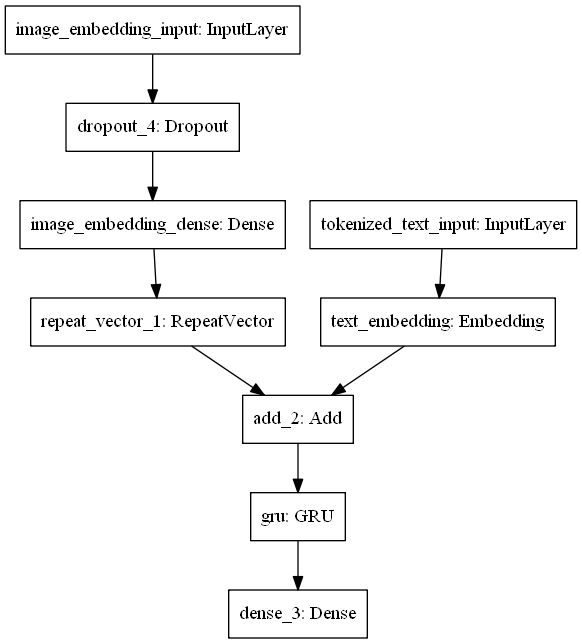

In [26]:
from tensorflow.keras.utils import plot_model
plot_model(model)

# Training

In [29]:
# wandb.init(config={"hyper": "parameter"}, project="proj_m")

EPOCHS = 2
# BATCH_SIZE = 35 # 6GB ram max. V100 32GB p3.2xlarge can fit 250.

# EPOCHS = 10
# BATCH_SIZE = 250

train_datagen = MemeDataGenerator(dataset=train_dataset, 
                                  img_embds=MEME_IMG_VEC,
                                  tokenizer=TOKENIZER,
                                  batch_size=BATCH_SIZE,
                                  max_length=MAX_LENGTH,
                                  vocab_size=VOCAB_SIZE)

val_datagen = MemeDataGenerator(dataset=val_dataset,
                                img_embds=MEME_IMG_VEC,
                                tokenizer=TOKENIZER,
                                batch_size=BATCH_SIZE,
                                max_length=MAX_LENGTH,
                                vocab_size=VOCAB_SIZE)

model = image_captioning_model(vocab_size=VOCAB_SIZE, 
                               maxlen=MAX_LENGTH, 
                               embedding_dim=256, 
                               rnn_units=256, 
                               batch_size=BATCH_SIZE)

filepath = f"../weights/ckpt/memefly-{Config.MODEL_TYPE}-{MAX_LENGTH}-{Config.TIMESTAMP}"+"-{epoch:02d}-{val_loss:.2f}.h5"
checkpoint = ModelCheckpoint(filepath, 
                             verbose=1, 
                             save_weights_only=False, 
                             save_best_only=False)

model.fit_generator(train_datagen, 
                    epochs=EPOCHS, 
                    verbose=1, 
                    validation_data=val_datagen,
                    callbacks=[checkpoint])
                    #callbacks=[WandbCallback(), checkpoint])

Epoch 1/2
553/554 [============================>.] - ETA: 1s - loss: 6.9877
Epoch 00001: saving model to ../weights/ckpt/memefly-word-150-201912062354-01-6.56.h5
554/554 [==============================] - 693s 1s/step - loss: 6.9874 - val_loss: 6.5648
Epoch 2/2
553/554 [============================>.] - ETA: 1s - loss: 6.1801
Epoch 00002: saving model to ../weights/ckpt/memefly-word-150-201912062354-02-5.94.h5
554/554 [==============================] - 697s 1s/step - loss: 6.1799 - val_loss: 5.9438
